**Goals of this notebook:**
 * Decompose the provided timeseries dataset with average temperatures into: trend, seasonality and remainder
  * In order to achieve that goal we will introduce timesteps and OneHotEncode 'months' and 'years' for the full dataset
  * We will Train/Test Split the data and calculate the R2 score for our first model
  * Finally we will subtract the effects of 'trend' and 'seasonality' from the true temperatures in order to get the 'remainders' of df_train
  * We use the pickle library to save the relevant results

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import pickle
import warnings

warnings.filterwarnings('ignore')

# Set figure size to (14,6)
plt.rcParams['figure.figsize'] = (30,6)
# Set some easthetic
sns.set()

In [2]:
df = pd.read_csv("./data/cologne_bonn.txt")

Information about data in columns:

* SOUID: Source identifier - 121044
* DATE : Date YYYYMMDD
* TG   : mean temperature in 0.1 &#176;C
* Q_TG : Quality code for TG (0='valid'; 1='suspect'; 9='missing')

### 1. EDA

In [3]:
df.head()

,SOUID,DATE,TG,Q_TG
0,121044,19570701,-9999,9
1,121044,19570702,-9999,9
2,121044,19570703,-9999,9
3,121044,19570704,-9999,9
4,121044,19570705,-9999,9


In [4]:
df.tail()

,SOUID,DATE,TG,Q_TG
23828,121044,20220926,102,0
23829,121044,20220927,96,0
23830,121044,20220928,97,0
23831,121044,20220929,88,0
23832,121044,20220930,98,0


In [5]:
df.shape

(23833, 4)

In [6]:
df.shape[0] / 365

65.2958904109589

In [7]:
df.describe()

,SOUID,DATE,TG,Q_TG
count,23833.0,2.383300e+04,23833.000000,23833.000000
mean,121044.0,1.989689e+07,76.570595,0.023455
std,0.0,1.883971e+05,519.168785,0.458494
min,121044.0,1.957070e+07,-9999.000000,0.000000
25%,121044.0,1.973102e+07,51.000000,0.000000
50%,121044.0,1.990021e+07,104.000000,0.000000
75%,121044.0,2.006061e+07,156.000000,0.000000
max,121044.0,2.022093e+07,310.000000,9.000000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23833 entries, 0 to 23832
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0    SOUID    23833 non-null  int64
 1       DATE  23833 non-null  int64
 2      TG     23833 non-null  int64
 3    Q_TG     23833 non-null  int64
dtypes: int64(4)
memory usage: 744.9 KB


### 2. Clean the data

In [9]:
# Removing whitespaces from column names
df.columns = [c_name.strip() for c_name in df.columns.tolist()]

In [10]:
df["Q_TG"].value_counts()

0    23770
9       62
1        1
Name: Q_TG, dtype: int64

Observation:

* The dataframe contains 62 missing values

In [11]:
# Inspect missing values
filter = df["Q_TG"] == 9
df[filter]

,SOUID,DATE,TG,Q_TG
0,121044,19570701,-9999,9
1,121044,19570702,-9999,9
2,121044,19570703,-9999,9
3,121044,19570704,-9999,9
4,121044,19570705,-9999,9
...,...,...,...,...
57,121044,19570827,-9999,9
58,121044,19570828,-9999,9
59,121044,19570829,-9999,9
60,121044,19570830,-9999,9


In [12]:
(62 / df.shape[0]) * 100

0.2601434985104687

* The missing values are from the period July to August 1957
* Missing values account only for 0.2% of the whole dataset and can therefore be dropped

In [13]:
df.drop(df[filter].index, inplace=True)
df["Q_TG"].value_counts()

0    23770
1        1
Name: Q_TG, dtype: int64

In [14]:
#After dropping the missing values df["Q_TG"] doesn't contain any valuable information
df.drop(["Q_TG"], axis=1, inplace=True)

In [15]:
#Resetting the index after dropping the 62 lines with missing values
df = df.reset_index(drop=True)

In [16]:
# Convert df["date"] to datatype datetime
df["DATE"] = pd.to_datetime(df["DATE"], format="%Y%m%d")
df.set_index("DATE", inplace=True)

In [17]:
# Drop df.["SOUID"] because it doesn't provide any helpful data
df.drop(["SOUID"], axis=1, inplace=True)

In [18]:
# Divide mean temperature by 10
df["TG"] = df["TG"] / 10

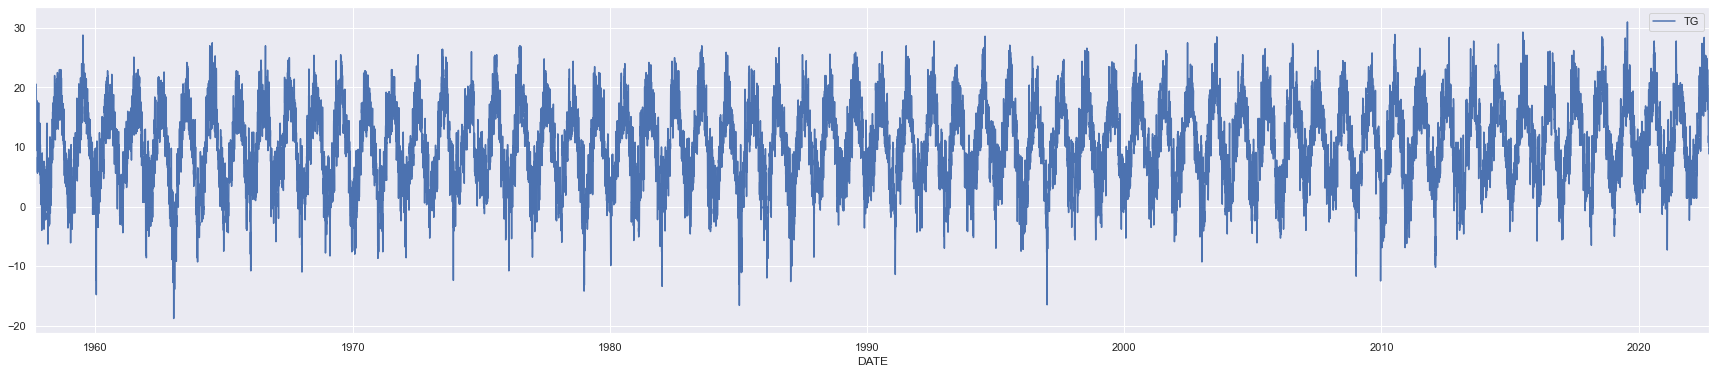

In [19]:
df.plot();

### 3. Decompose the timeseries

#### 3.1 Model the Trend

In [20]:
df['timestep'] = range(len(df))
df

,TG,timestep
DATE,,
1957-09-01,14.4,0
1957-09-02,13.2,1
1957-09-03,12.3,2
1957-09-04,12.6,3
1957-09-05,16.4,4
...,...,...
2022-09-26,10.2,23766
2022-09-27,9.6,23767
2022-09-28,9.7,23768


In [21]:
X = df[['timestep']]
y = df['TG']

In [22]:
m_trend = LinearRegression()

In [23]:
m_trend.fit(X,y)

LinearRegression()

In [24]:
df['trend'] = m_trend.predict(X)

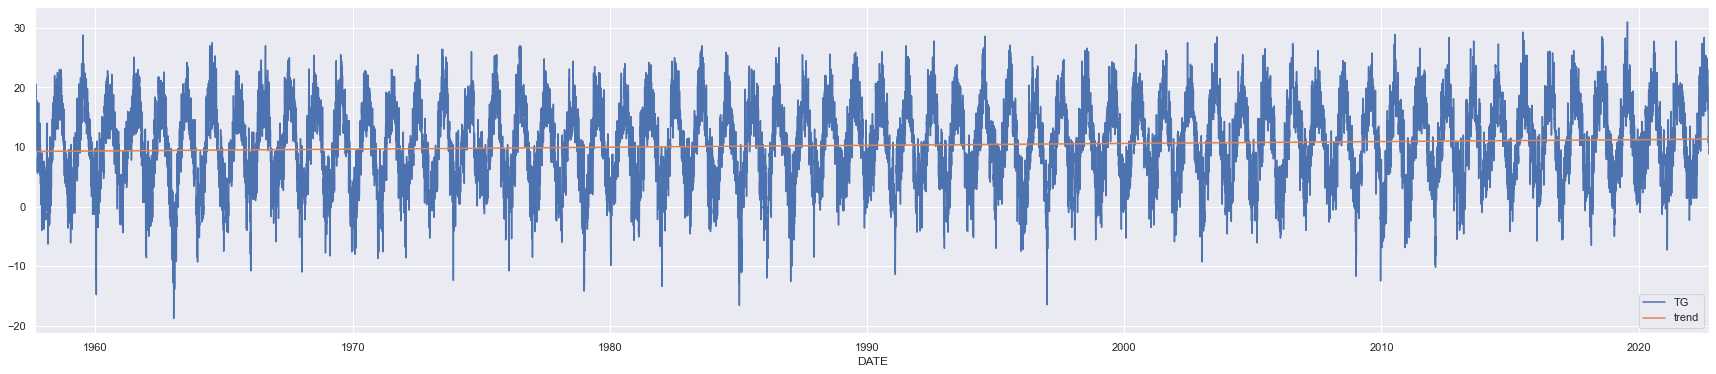

In [25]:
# Plot the trend line
df[["TG", "trend"]].plot();

#### 3.2 OneHotEncode months and years

In [26]:
# Create a separate line for the month 'value'
df['month'] = df.index.month
#df['year'] = df.index.year

In [27]:
seasonal_dummies_month = pd.get_dummies(
    data=df['month'],
    prefix='month',
    drop_first=True)
seasonal_dummies_month

,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
DATE,,,,,,,,,,,
1957-09-01,0,0,0,0,0,0,0,1,0,0,0
1957-09-02,0,0,0,0,0,0,0,1,0,0,0
1957-09-03,0,0,0,0,0,0,0,1,0,0,0
1957-09-04,0,0,0,0,0,0,0,1,0,0,0
1957-09-05,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2022-09-26,0,0,0,0,0,0,0,1,0,0,0
2022-09-27,0,0,0,0,0,0,0,1,0,0,0
2022-09-28,0,0,0,0,0,0,0,1,0,0,0


seasonal_dummies_year = pd.get_dummies(
    data=df['year'],
    prefix='year',
    drop_first=True)
seasonal_dummies_year

In [28]:
df = df.join(seasonal_dummies_month)
#df = df.join(seasonal_dummies_year)

In [29]:
df.head()

,TG,timestep,trend,month,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
DATE,,,,,,,,,,,,,,,
1957-09-01,14.4,0,9.252017,9,0,0,0,0,0,0,0,1,0,0,0
1957-09-02,13.2,1,9.252104,9,0,0,0,0,0,0,0,1,0,0,0
1957-09-03,12.3,2,9.252191,9,0,0,0,0,0,0,0,1,0,0,0
1957-09-04,12.6,3,9.252278,9,0,0,0,0,0,0,0,1,0,0,0
1957-09-05,16.4,4,9.252365,9,0,0,0,0,0,0,0,1,0,0,0


#### 4. Train/Test Split

In [30]:
train_filter = df.index <= "2021-09-30"
df_train = df[train_filter]

In [31]:
test_filter = df.index > "2021-09-30"
df_test = df[test_filter]

In [32]:
df_train.shape, df_test.shape

((23406, 15), (365, 15))

#### 5. Model the Trend_Seasonal model with df_train

In [33]:
#Drop selected columns
df_train.drop(['month', 'trend'], axis=1, inplace=True)

In [34]:
X = df_train.drop(['TG'], axis=1)
y= df_train['TG']
m_trend_seasonal = LinearRegression()
m_trend_seasonal.fit(X,y)

LinearRegression()

In [35]:
print(f"The R2 score of the 'trend_seasonal_model' for df_train is {round(m_trend_seasonal.score(X, y), 2)}")

The R2 score of the 'trend_seasonal_model' for df_train is 0.7


### 6. Add the predicted values from trend_seasonal and calculate the 'remainder' for df_test

In [36]:
df_train['trend_seasonal'] = m_trend_seasonal.predict(X)

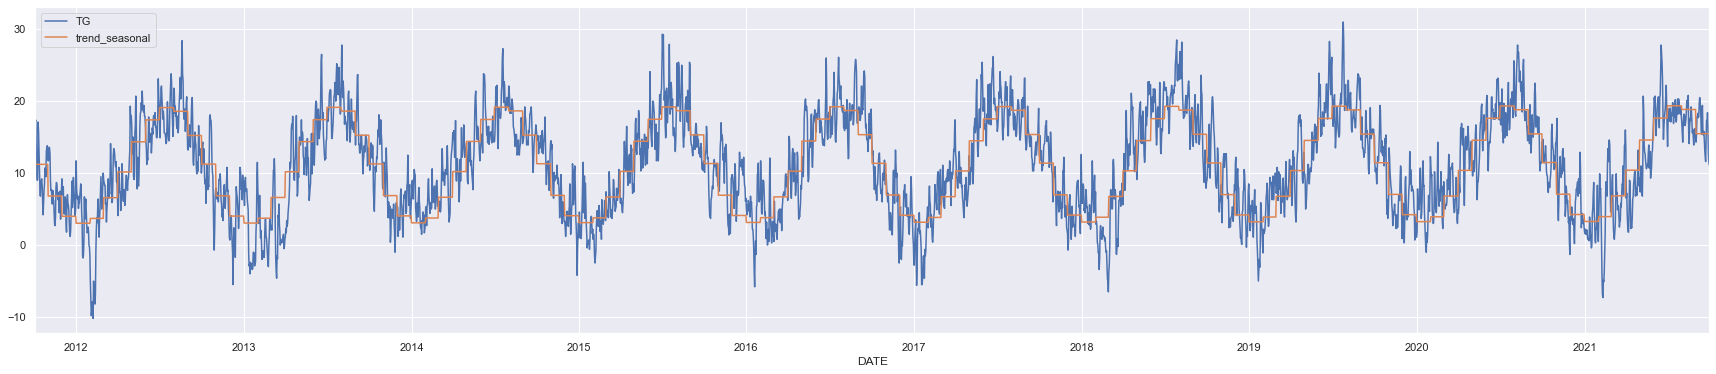

In [37]:
# Plot the original data and the trend with seasonality for the last ten years
df_train[["TG", "trend_seasonal"]].iloc[-3650:,:].plot();

In [38]:
#Calculate the remainder
df_train['remainder'] = df_train['TG'] - df_train['trend_seasonal']

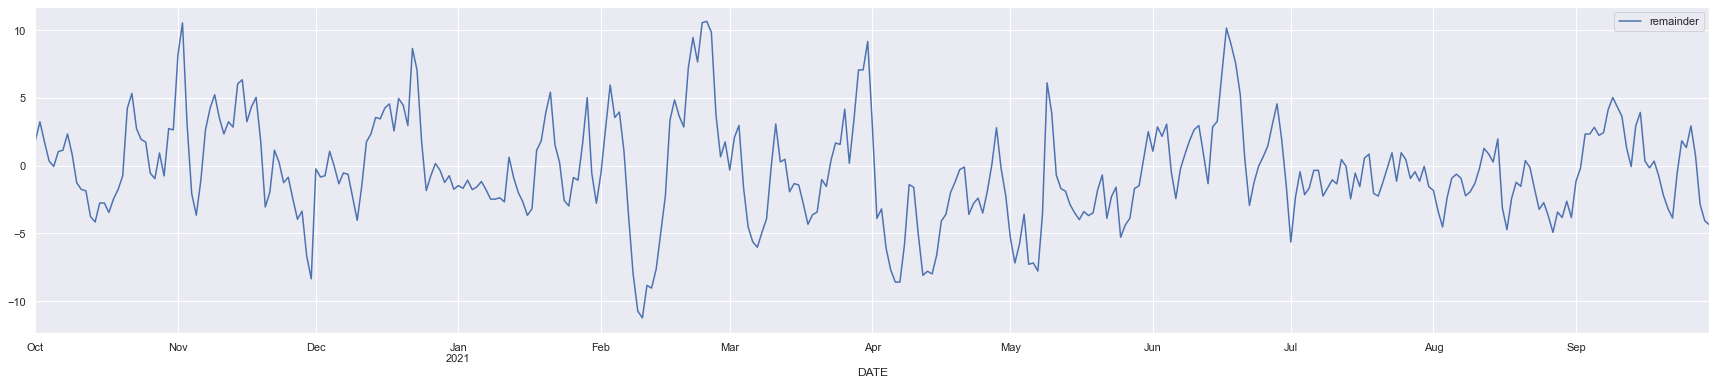

In [39]:
# Plot remainder for the last year in the train dataset
df_train[['remainder']].iloc[-365:,:].plot();

### 6. Save df_train, df_test and m_trend_seasonal with pickle

In [40]:
with open('./data/df_train.bin', 'wb') as f:
    pickle.dump(df_train, f)

In [41]:
with open('./data/df_test.bin', 'wb') as f:
    pickle.dump(df_test, f)

In [42]:
with open('./data/m_trend_seasonal.bin', 'wb') as f:
    pickle.dump(m_trend_seasonal, f)